In [42]:
import SimpleITK as sitk

def dicom_series_to_nifti(dicom_series_directory, output_nifti_file):
    # Read the DICOM series
    reader = sitk.ImageSeriesReader()
    dicom_series = reader.GetGDCMSeriesFileNames(dicom_series_directory)
    reader.SetFileNames(dicom_series)
    image = reader.Execute()

    # Write the image to NIfTI format
    sitk.WriteImage(image, output_nifti_file)

    print(f"Conversion successful. NIfTI file saved at {output_nifti_file}")

# Example usage
dicom_series_directory = '/nas/users/minhyeok/CMH/Broncho/test/N2_10000216'
output_nifti_file = "/nas/users/minhyeok/CMH/Broncho/test/N2_10000216.nii.gz"

dicom_series_to_nifti(dicom_series_directory, output_nifti_file)

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

Conversion successful. NIfTI file saved at /nas/users/minhyeok/CMH/Broncho/test/N1_10000216.nii.gz


In [1]:
import imageio
import shutil, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from pyvirtualdisplay import Display

N = 18
disp = Display().start()
import vtk
disp.stop()
def vtk_show(renderer, width = 512, height = 512, filename = ""):

    renderWindow = vtk.vtkRenderWindow()
    
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk. vtkPNGWriter()
    
    if filename == "":
        writer.SetWriteToMemory(1)
        writer.SetInputConnection(windowToImageFilter.GetOutputPort())
        writer.Write()    
        return bytes(memoryview(writer.GetResult()))
    else:
        writer.SetFileName(filename+".png")
        writer.SetInputConnection(windowToImageFilter.GetOutputPort())
        writer.Write()    
        return None

def vtk_render_gif(renderer, N, name, Roll = False, Azimuth = False, Elevation = False, Actor = None, RotateX = False, RotateY = False, RotateZ = False, Zoom = 0, Dolly = 0, standard = True, width = 512, height = 512):    
    if standard:
        renderer.ResetCamera()
        camera = renderer.MakeCamera()
        renderer.ResetCameraClippingRange()
        camera.SetPosition(0,0,0)
    os.makedirs(name, exist_ok=True)
    
    if Zoom != 0:
        renderer.GetActiveCamera().Zoom(Zoom)
        
    if Dolly != 0:
        renderer.GetActiveCamera().Dolly(Dolly)
        
    #tmpN = 1
    if N >0: # render gif
        for fi in range(N):
            if Roll:
                renderer.GetActiveCamera().Roll(360//N) 
            if Azimuth:
                renderer.GetActiveCamera().Azimuth(360//N) 
            if Elevation:
                renderer.GetActiveCamera().Elevation(360//N)
            if Actor is not None:
                if RotateX:
                    Actor.RotateX(360//N)
                if RotateY:
                    Actor.RotateY(360//N)
                if RotateZ:
                    Actor.RotateZ(360//N)                    
            vtk_show(renderer, filename = name + "/shot"+str(fi), width = width, height = height)
        # render gif and cleanup
        img_list = []
        for fi in range(N):
            img_list.append(mpimg.imread(name + '/shot' + str(fi) + '.png'))
        shutil.rmtree(name)
        imageio.mimsave(name + ".gif", img_list, duration=0.5)

    #if N == 1: # render png
       #vtk_show(renderer,filename = name + ".gif")

def CreateLut():
    colors = vtk.vtkNamedColors()

    colorLut = vtk.vtkLookupTable()
    colorLut.SetNumberOfColors(17)
    colorLut.SetTableRange(0, 16)
    colorLut.Build()

    colorLut.SetTableValue(0, 0, 0, 0, 0)
    colorLut.SetTableValue(1, colors.GetColor4d("salmon"))  # blood
    colorLut.SetTableValue(2, colors.GetColor4d("beige"))  # brain
    colorLut.SetTableValue(3, colors.GetColor4d("orange"))  # duodenum
    colorLut.SetTableValue(4, colors.GetColor4d("misty_rose"))  # eye_retina
    colorLut.SetTableValue(5, colors.GetColor4d("white"))  # eye_white
    colorLut.SetTableValue(6, colors.GetColor4d("tomato"))  # heart
    colorLut.SetTableValue(7, colors.GetColor4d("raspberry"))  # ileum
    colorLut.SetTableValue(8, colors.GetColor4d("banana"))  # kidney
    colorLut.SetTableValue(9, colors.GetColor4d("peru"))  # l_intestine
    colorLut.SetTableValue(10, colors.GetColor4d("pink"))  # liver
    colorLut.SetTableValue(11, colors.GetColor4d("powder_blue"))  # lung
    colorLut.SetTableValue(12, colors.GetColor4d("carrot"))  # nerve
    colorLut.SetTableValue(13, colors.GetColor4d("wheat"))  # skeleton
    colorLut.SetTableValue(14, colors.GetColor4d("violet"))  # spleen
    colorLut.SetTableValue(15, colors.GetColor4d("plum"))  # stomach

    return colorLut

def CreateTissueMap():
    tissueMap = dict()
    tissueMap["blood"] = 1
    tissueMap["brain"] = 2
    tissueMap["duodenum"] = 3
    tissueMap["eyeRetina"] = 4
    tissueMap["eyeWhite"] = 5
    tissueMap["heart"] = 6
    tissueMap["ileum"] = 7
    tissueMap["kidney"] = 8
    tissueMap["intestine"] = 9
    tissueMap["liver"] = 10
    tissueMap["lung"] = 11
    tissueMap["nerve"] = 12
    tissueMap["skeleton"] = 13
    tissueMap["spleen"] = 14
    tissueMap["stomach"] = 15

    return tissueMap

tissueMap = CreateTissueMap()

colorLut = CreateLut()

def CreateTissue(reader, ThrIn, ThrOut, color = "skeleton", isoValue = 127.5):
    selectTissue = vtk.vtkImageThreshold()
    selectTissue.ThresholdBetween(ThrIn,ThrOut)
    selectTissue.ReplaceInOn()
    selectTissue.SetInValue(255)
    selectTissue.ReplaceOutOn()
    selectTissue.SetOutValue(0)
    selectTissue.Update()
    selectTissue.SetInputConnection(reader.GetOutputPort())

    gaussianRadius = 5
    gaussianStandardDeviation = 2.0
    gaussian = vtk.vtkImageGaussianSmooth()
    gaussian.SetStandardDeviations(gaussianStandardDeviation, gaussianStandardDeviation, gaussianStandardDeviation)
    gaussian.SetRadiusFactors(gaussianRadius, gaussianRadius, gaussianRadius)
    gaussian.SetInputConnection(selectTissue.GetOutputPort())

    #isoValue = 127.5
    mcubes = vtk.vtkMarchingCubes()
    mcubes.SetInputConnection(gaussian.GetOutputPort())
    mcubes.ComputeScalarsOff()
    mcubes.ComputeGradientsOff()
    mcubes.ComputeNormalsOff()
    mcubes.SetValue(0, isoValue)

    smoothingIterations = 5
    passBand = 0.001
    featureAngle = 60.0
    smoother = vtk.vtkWindowedSincPolyDataFilter()
    smoother.SetInputConnection(mcubes.GetOutputPort())
    smoother.SetNumberOfIterations(smoothingIterations)
    smoother.BoundarySmoothingOff()
    smoother.FeatureEdgeSmoothingOff()
    smoother.SetFeatureAngle(featureAngle)
    smoother.SetPassBand(passBand)
    smoother.NonManifoldSmoothingOn()
    smoother.NormalizeCoordinatesOn()
    smoother.Update()

    normals = vtk.vtkPolyDataNormals()
    normals.SetInputConnection(smoother.GetOutputPort())
    normals.SetFeatureAngle(featureAngle)

    stripper = vtk.vtkStripper()
    stripper.SetInputConnection(normals.GetOutputPort())

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(stripper.GetOutputPort())

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor( colorLut.GetTableValue(tissueMap[color])[:3])
    actor.GetProperty().SetSpecular(.5)
    actor.GetProperty().SetSpecularPower(10)
    
    return actor

def render_lungs(workdir, datadir, patient):
    PathDicom = datadir + patient
    reader = vtk.vtkDICOMImageReader()
    reader.SetDirectoryName(PathDicom)
    reader.Update()    
    disp = Display().start()
    renderer = vtk.vtkRenderer()
    actor = CreateTissue(reader,-2000,-300,"lung", isoValue = 170)
    renderer.AddActor(actor)
    renderer.SetBackground(1.0, 1.0, 1.0)

    renderer.ResetCamera()
    renderer.ResetCameraClippingRange()
    camera = renderer.GetActiveCamera()
    camera.Elevation(120)
    camera.Elevation(120)
    renderer.SetActiveCamera(camera)

    name = workdir + patient + '_lungs'

    vtk_render_gif(renderer, 1, name, Dolly = 1.5,width = 400, height = 400)
    disp.stop()
    gc.collect()

In [1]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes(p, threshold, method='lewiner')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

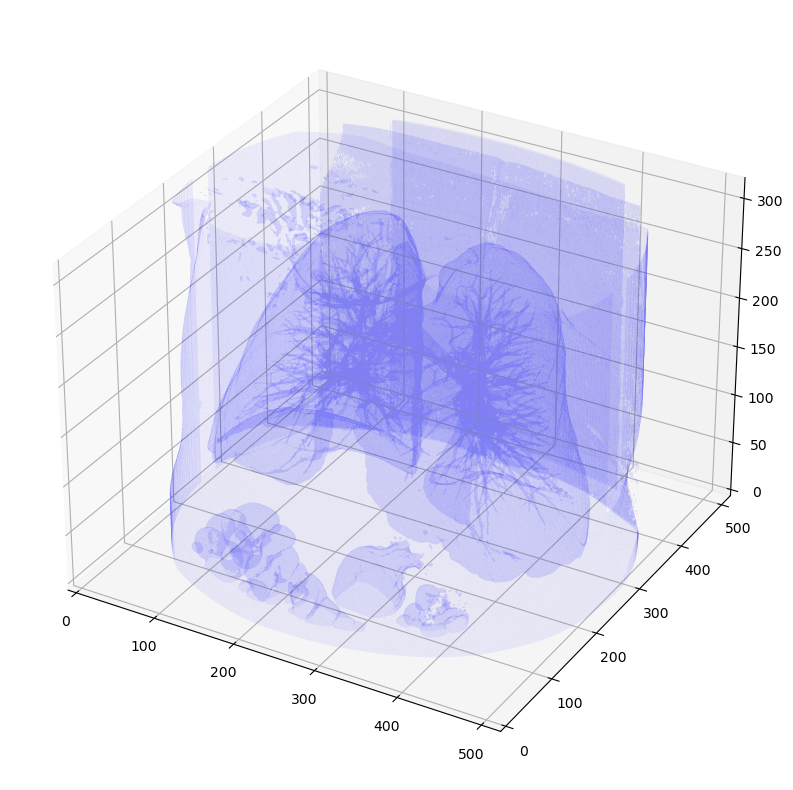

In [4]:
import SimpleITK as sitk
datadir = '/nas/dataset/users/minhyeok/LDCT/C001/Full/'

reader = sitk.ImageSeriesReader()
dicom_series = reader.GetGDCMSeriesFileNames(datadir)
reader.SetFileNames(dicom_series)
obj = reader.Execute()

array = sitk.GetArrayFromImage(obj)

plot_3d(array)

(154, 512, 512)


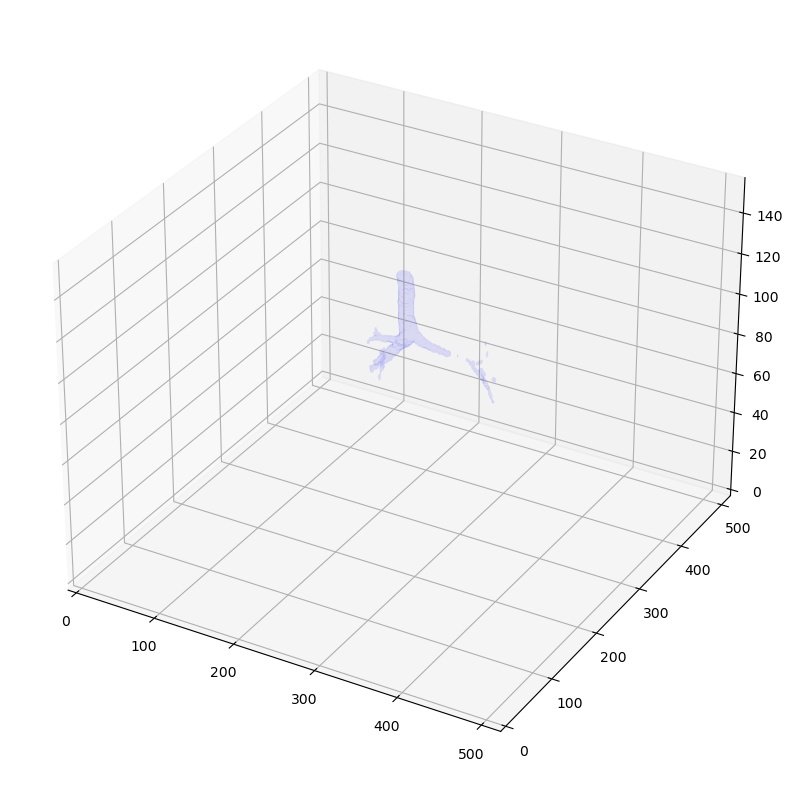

In [6]:
niftidir = '/nas/users/minhyeok/CMH/Broncho/test/N1_bronchia.nii.gz'
nifti = sitk.ReadImage(niftidir)
nifti_arr = sitk.GetArrayFromImage(nifti)
print(nifti_arr.shape)
plot_3d(nifti_arr, 0.0)

(281, 512, 512)


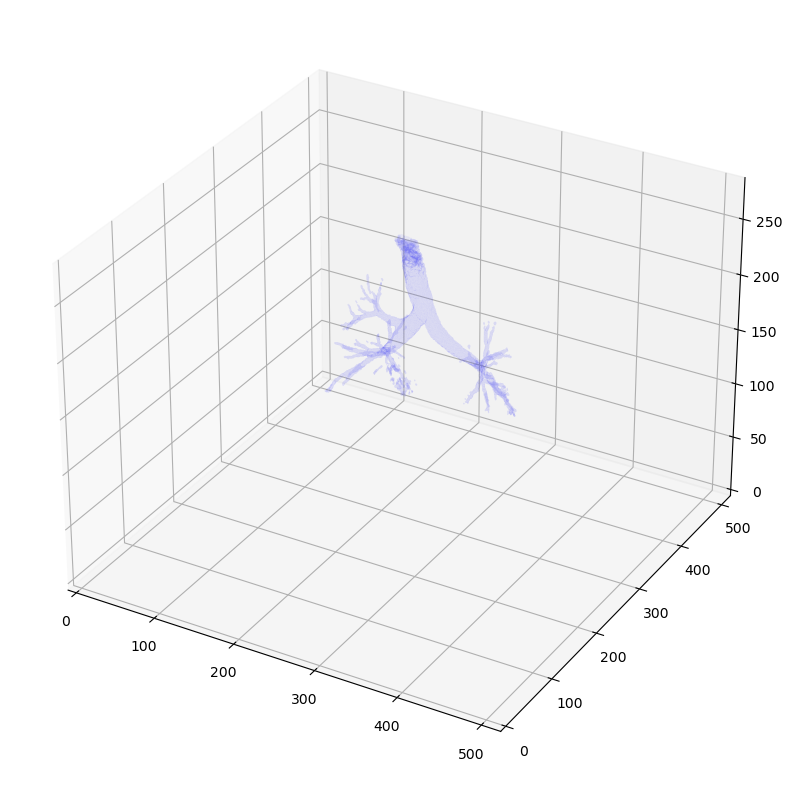

In [4]:
niftidir = '/nas/users/minhyeok/CMH/Broncho/C009_bronchia.nii.gz'
nifti = sitk.ReadImage(niftidir)
nifti_arr = sitk.GetArrayFromImage(nifti)
print(nifti_arr.shape)
plot_3d(nifti_arr, 0.0)

(77, 512, 512)


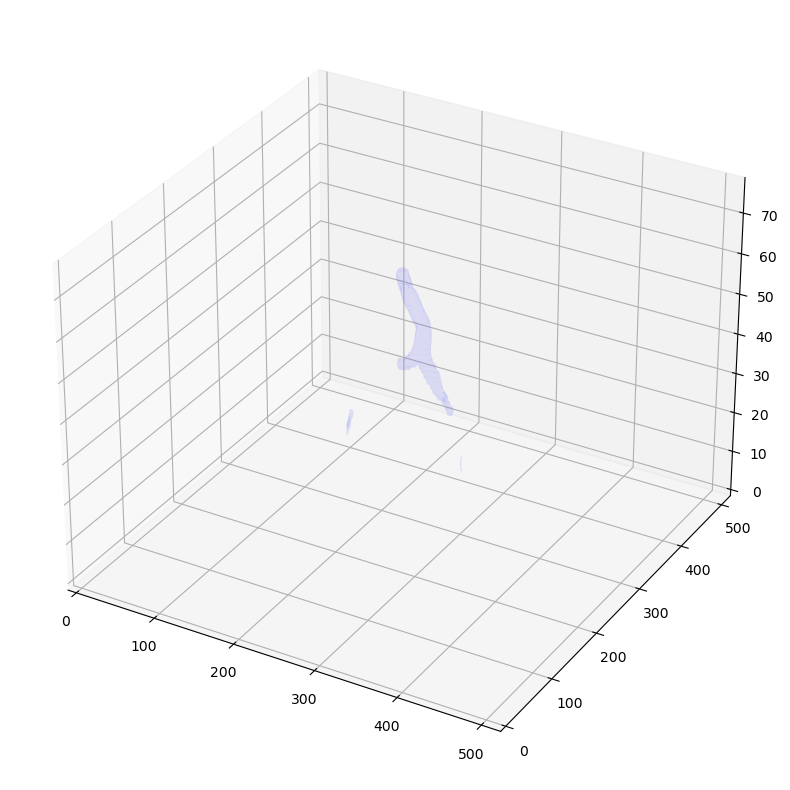

In [2]:
import SimpleITK as sitk
niftidir = '/nas/users/minhyeok/CMH/Broncho/test/N2_bronchia.nii.gz'
nifti = sitk.ReadImage(niftidir)
nifti_arr = sitk.GetArrayFromImage(nifti)
print(nifti_arr.shape)
plot_3d(nifti_arr, 0.0)

In [8]:
path='/nas/users/minhyeok/CMH/Broncho/test/N2_10000216/*'
import glob, os
caselist = sorted(glob.glob(path))
# caselist[33:187]
# for case in caselist[154:]:
#     os.remove(case)

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017102.dcm


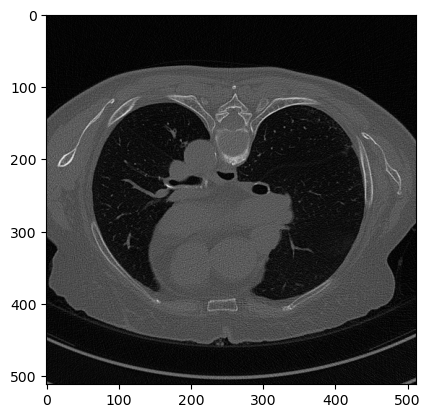

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017103.dcm


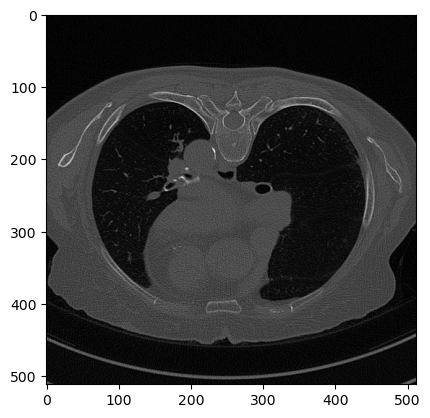

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017104.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

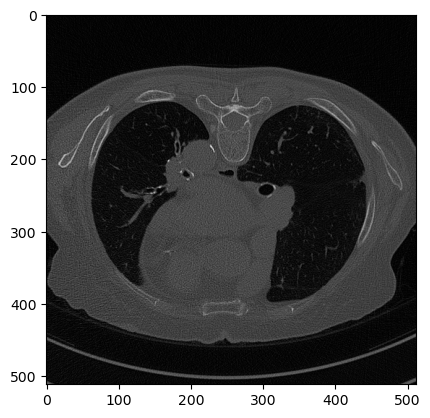

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017105.dcm


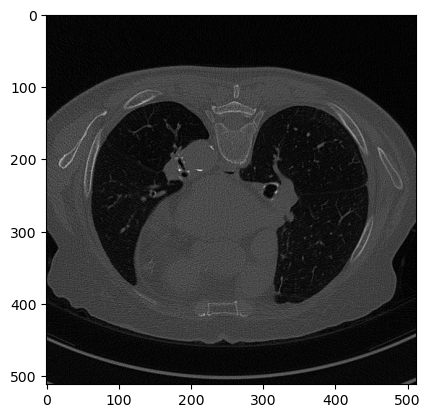

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017106.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

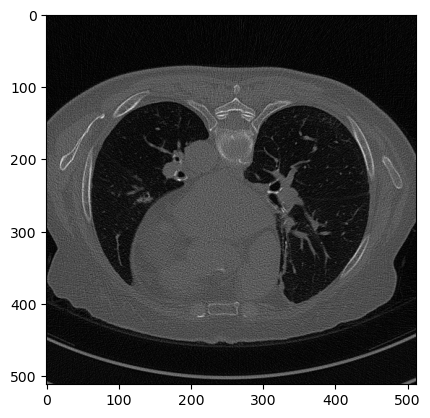

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017107.dcm


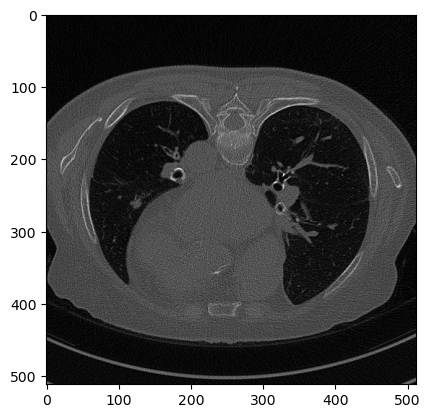

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017108.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

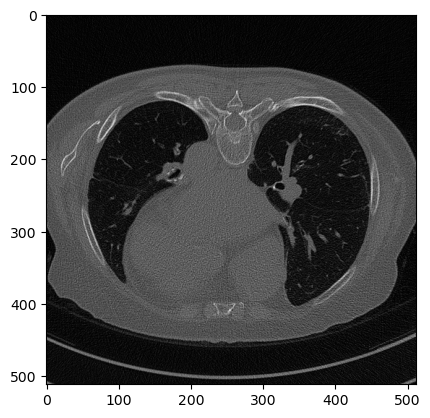

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017109.dcm


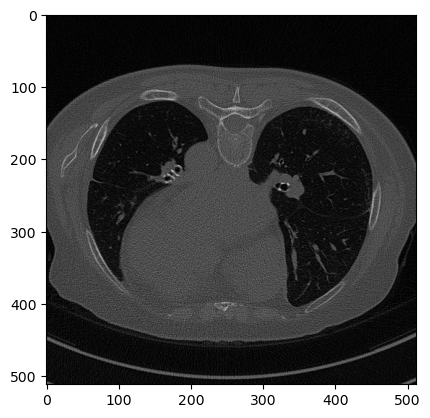

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017110.dcm


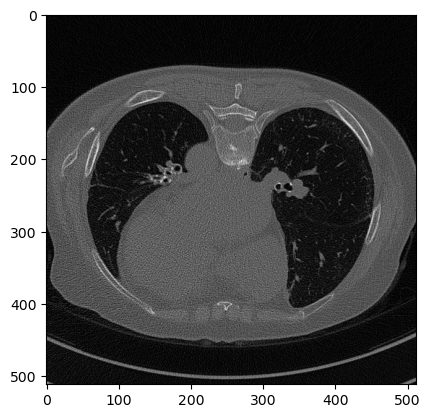

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017111.dcm


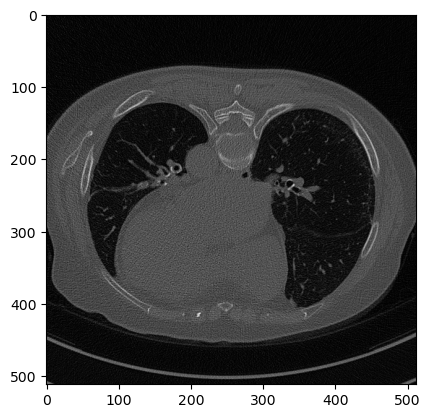

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017112.dcm


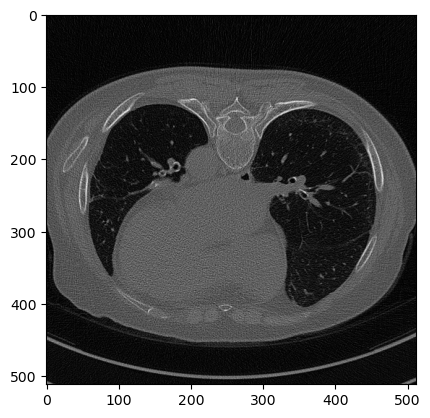

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017113.dcm


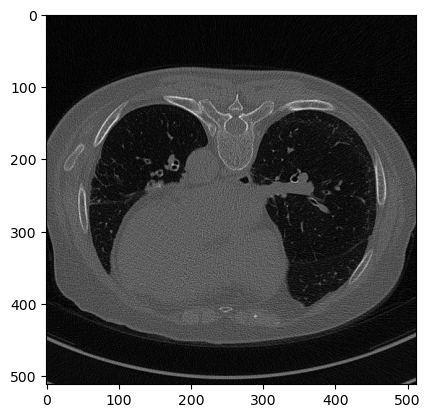

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017114.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

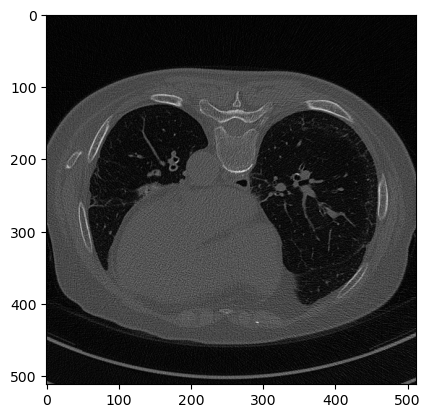

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017115.dcm


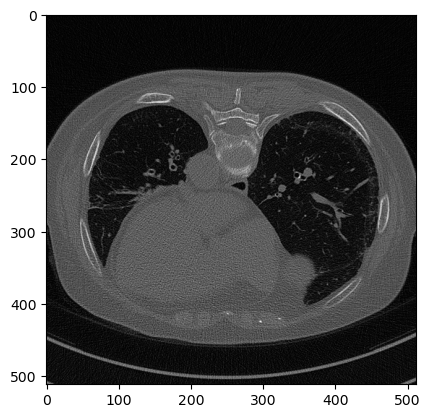

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017116.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

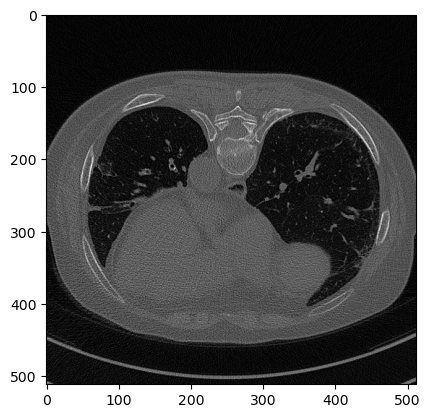

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017117.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

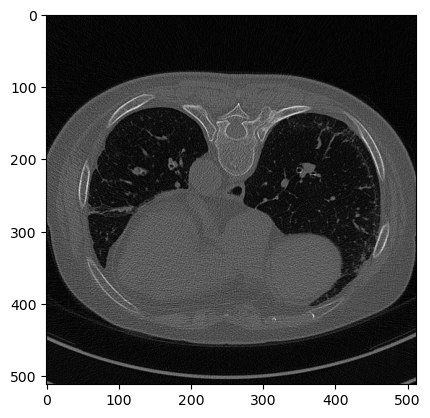

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017118.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

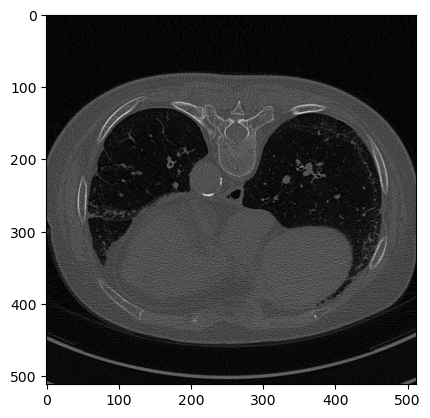

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017119.dcm


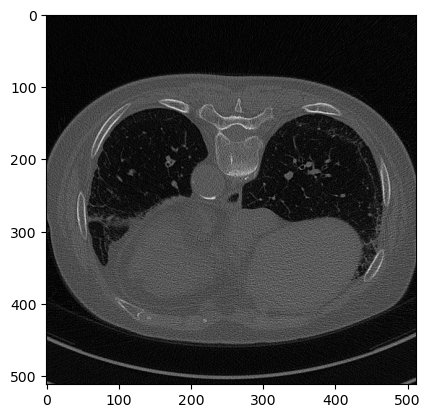

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017120.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

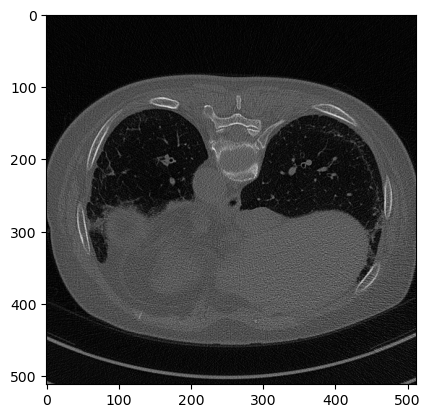

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017121.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

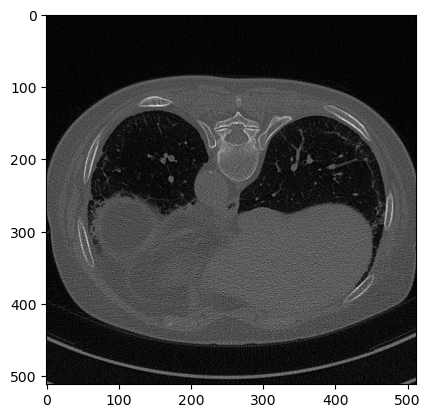

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017122.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

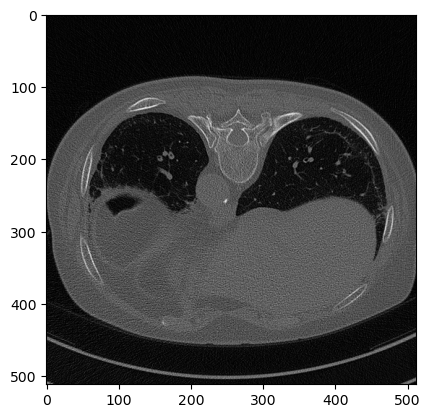

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017123.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

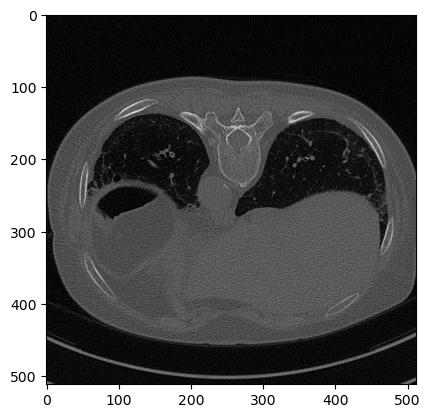

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017124.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

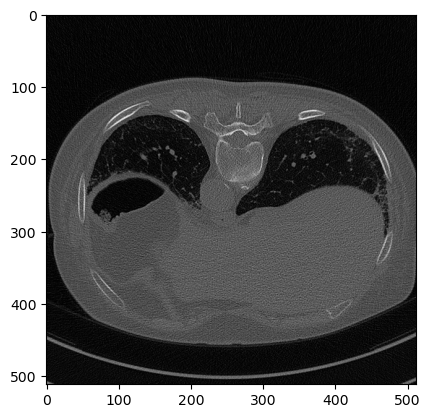

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017125.dcm


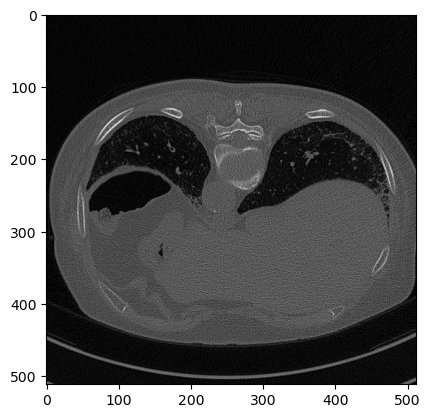

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017126.dcm


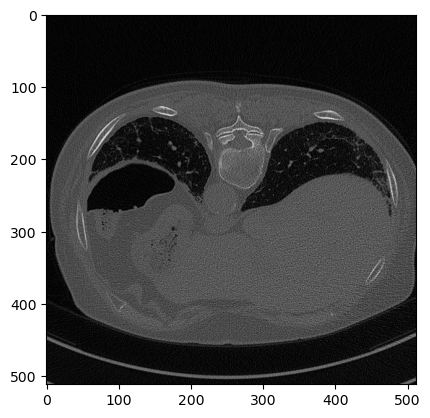

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017127.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

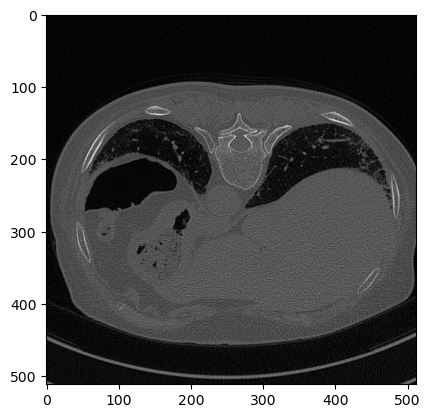

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017128.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

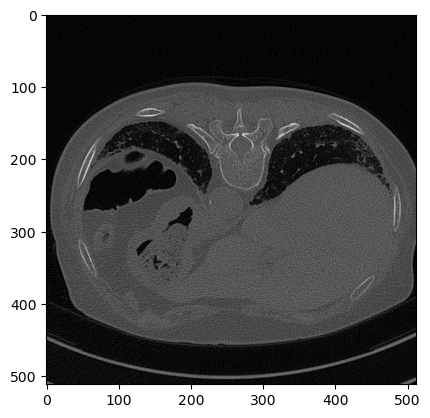

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017129.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

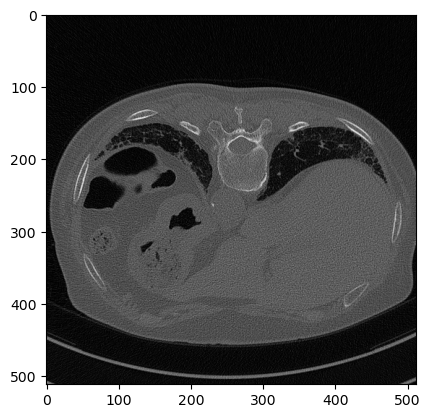

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017130.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

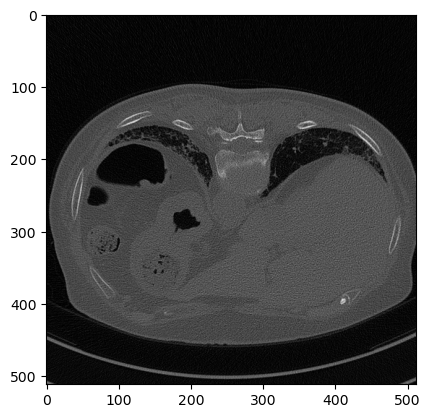

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017131.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

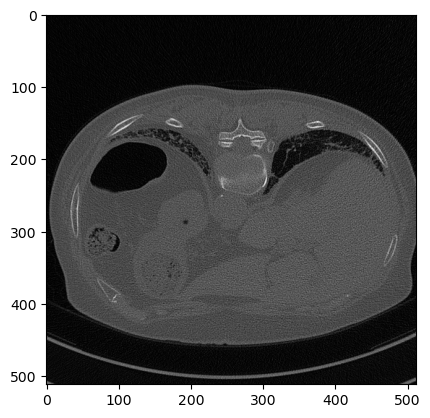

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017132.dcm


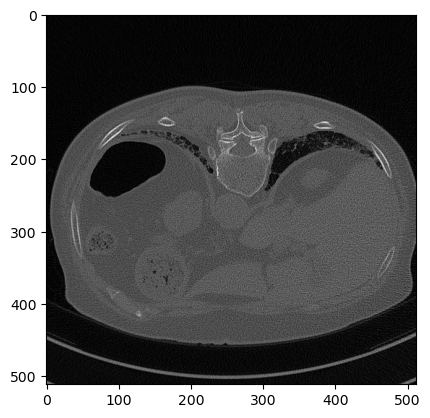

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017133.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

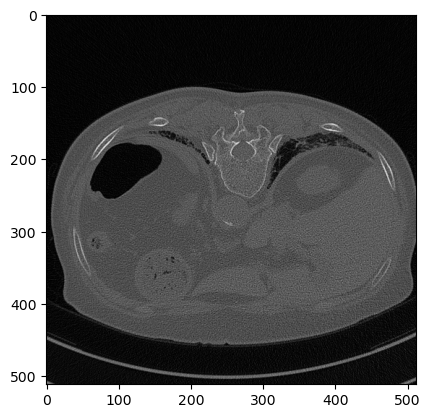

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017134.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

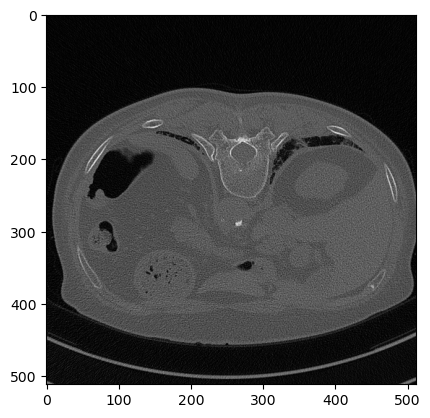

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017135.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

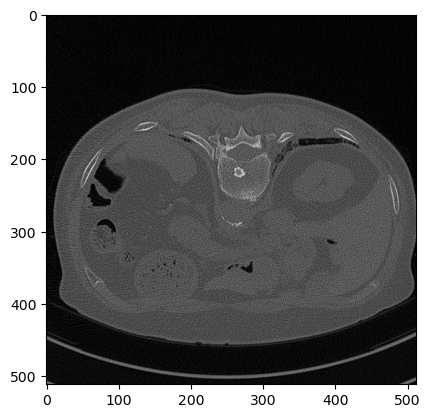

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017136.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

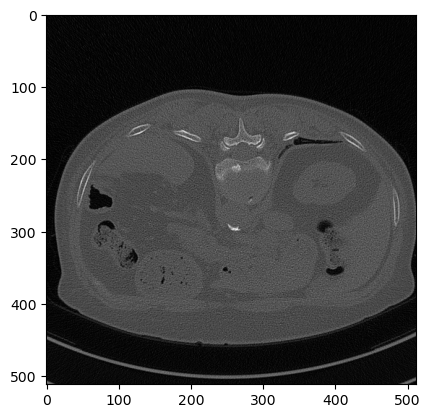

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017137.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

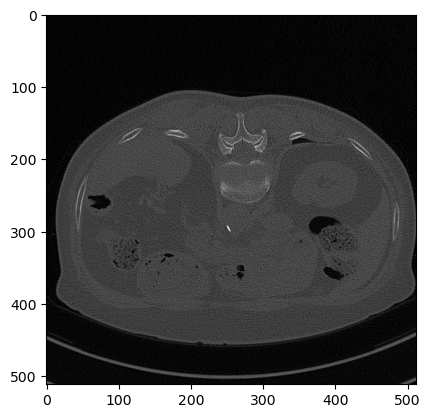

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017138.dcm


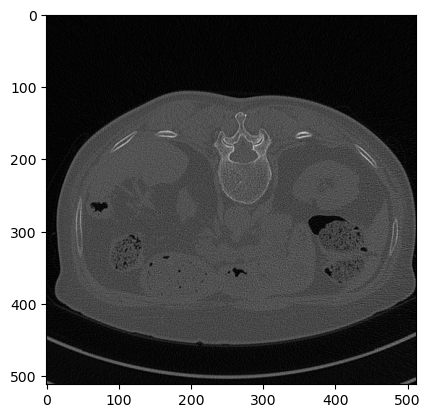

No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017139.dcm


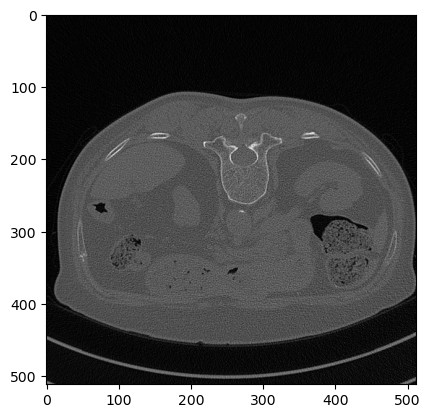

(1, 512, 512) /nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017140.dcm


No DICOM magic number found, but the file appears to be DICOM without a preamble.
Proceeding without caution.

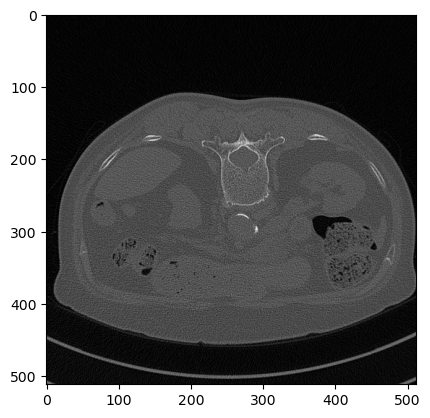

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/nas/users/minhyeok/CMH/Broncho/test/N2_10000216/20161017141.dcm" does not exist.

In [10]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
for case in caselist[100:]:
    obj = sitk.ReadImage(case)
    arr = sitk.GetArrayFromImage(obj)
    print(arr.shape, case)
    plt.imshow(arr[0], 'gray')
    plt.show()

In [5]:
from totalsegmentator.python_api import totalsegmentator
input_path = '/nas/users/minhyeok/CMH/Broncho/test/N1_10000216.nii.gz'
output_path = '/nas/users/minhyeok/CMH/Broncho/test'
if __name__ == "__main__":
    totalsegmentator(input_path, output_path, task='lung_vessels')


If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024



ValueError: task lung_vessels does not work with option --fast